In [1]:
import os
from pathlib import Path

import comet_ml
import tensorflow as tf
import torch
import torch.optim as optim
# import sys; sys.path.append('../rsl_depth_completion/conditional_diffusion/')
from rsl_depth_completion.conditional_diffusion.load_data import load_data
from rsl_depth_completion.conditional_diffusion.config import cfg as cfg_cls
from rsl_depth_completion.conditional_diffusion.utils import log_params_to_exp
from rsl_depth_completion.diffusion.utils import set_seed
cfg=cfg_cls(path=cfg_cls.default_file)
set_seed(cfg.seed)
torch.backends.cudnn.benchmark = True

if cfg.is_cluster:
    if not os.path.exists(f"{cfg.tmpdir}/cluster"):
        os.system(f"tar -xvf /cluster/project/rsl/kzaitsev/dataset.tar -C {cfg.tmpdir}")

import itertools
import shutil


def product_dict(**kwargs):
    keys = kwargs.keys()
    for instance in itertools.product(*kwargs.values()):
        yield dict(zip(keys, instance))
ds_params_full = product_dict(
    use_text_embed=[True, False],
    use_cond_image=[True, False],
    use_rgb_as_cond_image=[True, False],
)
ds_params = [
    list(ds_params_full)[-1]
]
ds_params
for ds_name in ["mnist"]:
    for ds_kwargs in ds_params:
        ds_kwargs["use_rgb_as_text_embed"] = not ds_kwargs["use_rgb_as_cond_image"]
        ds_kwargs["include_sdm_and_rgb_in_sample"] = True
        ds_kwargs["do_crop"] = True
        print(ds_kwargs)

        ds, train_dataloader, val_dataloader = load_data(
            ds_name=ds_name, do_overfit=True, cfg=cfg,**ds_kwargs
        )

Found cached dataset fashion_mnist (/media/master/wext/cv_data/hf_home/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48)


  0%|          | 0/2 [00:00<?, ?it/s]

{'use_text_embed': False, 'use_cond_image': False, 'use_rgb_as_cond_image': False, 'use_rgb_as_text_embed': True, 'include_sdm_and_rgb_in_sample': True, 'do_crop': True}


In [2]:
from tqdm.auto import tqdm


if True:
    data_gen = enumerate(train_dataloader)
else:
    data_gen = tqdm(
        enumerate(train_dataloader), total=len(train_dataloader)
    )
batch = next(data_gen)[1]
images = batch["image"].to(cfg.device)

In [3]:
batch[input_img].device

device(type='cpu')

In [4]:
from dataclasses import dataclass


@dataclass
class TrainingConfig:
    image_size = 64  # the generated image resolution
    train_batch_size = 1
    eval_batch_size = 1  # how many images to sample during evaluation
    num_epochs = 2
    gradient_accumulation_steps = 1
    learning_rate = 5e-5
    lr_warmup_steps = 500
    save_image_epochs = 10
    save_model_epochs = 30
    mixed_precision = "fp16"  # `no` for float32, `fp16` for automatic mixed precision
    output_dir = "ddpm-butterflies-128"  # the model name locally and on the HF Hub

    push_to_hub = False  # whether to upload the saved model to the HF Hub
    hub_private_repo = False
    overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    seed = 0

    num_train_timesteps=300
    num_inference_timesteps=300


config = TrainingConfig()

In [5]:
from diffusers import UNet2DModel

model = UNet2DModel(
    sample_size=config.image_size,  # the target image resolution
    in_channels=1,  # the number of input channels, 3 for RGB images
    out_channels=1,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(128, 128, 256, 256, 512, 512),  # the number of output channels for each UNet block
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)

In [6]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

113668609

In [7]:
import gc; gc.collect()
torch.cuda.empty_cache()

In [8]:
sample_image = ds[0]["image"].unsqueeze(0)
print("Input shape:", sample_image.shape)
print("Output shape:", model(sample_image, timestep=0).sample.shape)

Input shape: torch.Size([1, 1, 64, 64])
Output shape: torch.Size([1, 1, 64, 64])


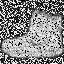

In [9]:
import torch
from PIL import Image
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=config.num_train_timesteps)
noise = torch.randn(sample_image.shape)
timesteps = torch.LongTensor([50])
noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)

Image.fromarray(((noisy_image.permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).numpy()[0][:,:,-1], 'L')

In [10]:
import torch.nn.functional as F

noise_pred = model(noisy_image, timesteps).sample
loss = F.mse_loss(noise_pred, noise)

In [11]:
from diffusers.optimization import get_cosine_schedule_with_warmup

optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)
# lr_scheduler = get_cosine_schedule_with_warmup(
#     optimizer=optimizer,
#     num_warmup_steps=config.lr_warmup_steps,
#     num_training_steps=(len(train_dataloader) * config.num_epochs),
# )
lr_scheduler=None

In [12]:
from diffusers import DDPMPipeline
import math
import os


def make_grid(images, rows, cols):
    w, h = images[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    for i, image in enumerate(images):
        grid.paste(image, box=(i % cols * w, i // cols * h))
    return grid


def evaluate(config, epoch, pipeline):
    # Sample some images from random noise (this is the backward diffusion process).
    # The default pipeline output type is `List[PIL.Image]`
    images = pipeline(
        batch_size=config.eval_batch_size,
        generator=torch.manual_seed(config.seed),
        num_inference_steps=config.num_inference_timesteps,
    ).images

    # Make a grid out of the images
    image_grid = make_grid(images, rows=4, cols=4)

    # Save the images
    test_dir = os.path.join(config.output_dir, "samples")
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f"{test_dir}/{epoch:04d}.png")

In [13]:
from accelerate import Accelerator
from huggingface_hub import HfFolder, Repository, whoami
from tqdm.auto import tqdm
from pathlib import Path
import os


def get_full_repo_name(model_id: str, organization: str = None, token: str = None):
    if token is None:
        token = HfFolder.get_token()
    if organization is None:
        username = whoami(token)["name"]
        return f"{username}/{model_id}"
    else:
        return f"{organization}/{model_id}"


def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    # Initialize accelerator and tensorboard logging
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        log_with="tensorboard",
        logging_dir=os.path.join(config.output_dir, "logs"),
    )
    if accelerator.is_main_process:
        if config.push_to_hub:
            repo_name = get_full_repo_name(Path(config.output_dir).name)
            repo = Repository(config.output_dir, clone_from=repo_name)
        elif config.output_dir is not None:
            os.makedirs(config.output_dir, exist_ok=True)
        accelerator.init_trackers("train_example")

    # Prepare everything
    # There is no specific order to remember, you just need to unpack the
    # objects in the same order you gave them to the prepare method.
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )

    global_step = 0

    # Now you train the model
    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader), disable=True or not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            
            if step == 1: break

            clean_images = batch["image"]
            # Sample noise to add to the images
            noise = torch.randn(clean_images.shape).to(clean_images.device)
            bs = clean_images.shape[0]

            # Sample a random timestep for each image
            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps, (bs,), device=clean_images.device
            ).long()

            # Add noise to the clean images according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

            with accelerator.accumulate(model):
                # Predict the noise residual
                noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, noise)
                accelerator.backward(loss)

                accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                # lr_scheduler.step()
                optimizer.zero_grad()

            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "lr": optimizer.optimizer.param_groups[0]['lr'], "step": global_step}
            # logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1

        # After each epoch you optionally sample some demo images with evaluate() and save the model
        if accelerator.is_main_process:
            pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler,
            )

            if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
                print(f'Epoch: {epoch}\t{logs}')
                evaluate(config, epoch, pipeline)

            if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                if config.push_to_hub:
                    repo.push_to_hub(commit_message=f"Epoch {epoch}", blocking=True)
                else:
                    pipeline.save_pretrained(config.output_dir)

In [14]:

args = (config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)

config.num_epochs = 2000
config.save_image_epochs=100
config.eval_batch_size = 2
train_loop(*args)

/opt/miniconda3/envs/ssdc/lib/python3.10/site-packages/accelerate/accelerator.py:258: FutureWarning: `logging_dir` is deprecated and will be removed in version 0.18.0 of 🤗 Accelerate. Use `project_dir` instead.
  warnings.warn(


Epoch: 99	{'loss': 0.023565299808979034, 'lr': 5e-05, 'step': 99}


  0%|          | 0/300 [00:00<?, ?it/s]

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:9                                                                                    │
│                                                                                                  │
│    6 config.num_epochs = 2000                                                                    │
│    7 config.save_image_epochs=100                                                                │
│    8 config.eval_batch_size = 2                                                                  │
│ ❱  9 train_loop(*args)                                                                           │
│   10                                                                                             │
│                                                                                                  │
│ in train_loop:97                                                                                 │
│                                                                                                  │
│   94 │   │   │   │   if config.push_to_hub:                                                      │
│   95 │   │   │   │   │   repo.push_to_hub(commit_message=f"Epoch {epoch}", blocking=True)        │
│   96 │   │   │   │   else:                                                                       │
│ ❱ 97 │   │   │   │   │   pipeline.save_pretrained(config.output_dir)                             │
│   98                                                                                             │
│                                                                                                  │
│ /opt/miniconda3/envs/ssdc/lib/python3.10/site-packages/diffusers/pipelines/pipeline_utils.py:607 │
│ in save_pretrained                                                                               │
│                                                                                                  │
│    604 │   │   │   if save_method_accept_variant:                                                │
│    605 │   │   │   │   save_kwargs["variant"] = variant                                          │
│    606 │   │   │                                                                                 │
│ ❱  607 │   │   │   save_method(os.path.join(save_directory, pipeline_component_name), **save_kw  │
│    608 │   │                                                                                     │
│    609 │   │   # finally save the config                                                         │
│    610 │   │   self.save_config(save_directory)                                                  │
│                                                                                                  │
│ /opt/miniconda3/envs/ssdc/lib/python3.10/site-packages/diffusers/models/modeling_utils.py:323 in │
│ save_pretrained                                                                                  │
│                                                                                                  │
│   320 │   │   │   │   state_dict, os.path.join(save_directory, weights_name), metadata={"forma   │
│   321 │   │   │   )                                                                              │
│   322 │   │   else:                                                                              │
│ ❱ 323 │   │   │   torch.save(state_dict, os.path.join(save_directory, weights_name))             │
│   324 │   │                                                                                      │
│   325 │   │   logger.info(f"Model weights saved in {os.path.join(save_directory, weights_name)   │
│   326                                                                                            │
│                                                                                                  │
│ /opt/miniconda3/envs/ssdc/lib/python3.10/site-packages/come